# Example reduction

In [1]:
import sys
import os
sys.path.append(os.path.expanduser('~/git/LiquidsReflectometer/reduction'))

import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

#%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

In [2]:
import mantid
import mantid.simpleapi as api
mantid.kernel.config.setLogLevel(3)

logging set to error priority


In [3]:
print(mantid.__version__)
print(sys.version)

6.9.20240320.1649
3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [4]:
import importlib
import lr_reduction
from lr_reduction import workflow
from lr_reduction import template
from lr_reduction import output
from lr_reduction import event_reduction
from lr_reduction import reduction_template_reader


In [5]:
importlib.reload(workflow)
importlib.reload(output)
importlib.reload(event_reduction)
importlib.reload(template)

# To test dead time correction
# run=[206593,206594,206595,206596,206597,206598,206599,206600]
# rate=[49805,34762,21197,12198,8020,4542,2254,569]

data_dir = os.path.expanduser('~/git/LiquidsReflectometer/reduction/data')
template_path = os.path.join(data_dir, 'template.xml')

os.chdir(os.path.expanduser('~/git/LiquidsReflectometer/reduction'))

for i in range(198409, 198417):
    ws = api.Load("REF_L_%s" % i)
    workflow.reduce(ws, template_path, output_dir=data_dir, average_overlap=False)


wl=15; ths=-0.600382; thi=-0.00812677; No offset
Background on both sides: [133 135] [148 150]
Normalization options: True True
wl=12.386; ths=-0.600058; thi=-0.00812677; No offset
Background on both sides: [133 135] [148 150]
Normalization options: True True
wl=9.74; ths=-0.600058; thi=-0.00812677; No offset
Background on both sides: [133 135] [148 150]
Normalization options: True True
wl=7.043; ths=-0.599896; thi=-0.00812677; No offset
Background on both sides: [133 135] [148 150]
Normalization options: True True
wl=4.25; ths=-0.599733; thi=-0.00812677; No offset
Background on both sides: [133 135] [148 150]
Normalization options: True True
wl=4.25; ths=-1.18271; thi=-0.00812677; No offset
Background on both sides: [133 135] [148 150]
Normalization options: True True
wl=4.25; ths=-2.34284; thi=-0.00812677; No offset
Background on both sides: [131 133] [149 151]
Normalization options: True True
wl=4.25; ths=-4.63906; thi=-0.00812677; No offset
Background on both sides: [131 133] [149 

In [83]:
importlib.reload(workflow)
importlib.reload(output)
importlib.reload(event_reduction)
importlib.reload(template)

# To test dead time correction
# run=[206593,206594,206595,206596,206597,206598,206599,206600]
# rate=[49805,34762, 21197, 12198, 8020,  4542,  2254,  569]

data_dir = os.path.expanduser('~/git/LiquidsReflectometer/reduction/data')
template_path = os.path.join(data_dir, 'template_high_rate_206594.xml')
template_path = os.path.join(data_dir, 'template_high_rate_206595.xml')
template_path = os.path.join(data_dir, '206780_rate_206594.xml')

os.chdir(os.path.expanduser('~/git/LiquidsReflectometer/reduction'))

for i in range(206784, 206787):
    ws = api.Load("REF_L_%s" % i)
    sequence_number = ws.getRun().getProperty("sequence_number").value[0]
    template_data = template.read_template(template_path, sequence_number)
    template_data.dead_time = True
    template_data.paralyzable = True
    workflow.reduce(ws, template_data, output_dir=data_dir, average_overlap=False)

wl=4.25; ths=0.599896; thi=-0.0140861; No offset
Background on both sides: [132 134] [147 149]
Background on both sides: [132 134] [144 146]
Dead time correction: [4.96042e-321 -> 0.917482] at [0.0220792 -> 0.0225208]
Normalization options: True True
Template data was passed instead of a file path: template data not saved
wl=4.25; ths=1.1832; thi=-0.0140861; No offset
Background on both sides: [132 134] [147 149]
Background on both sides: [132 134] [144 146]
Dead time correction: [0 -> 0.903899] at [0.099448 -> 0.045039]
Normalization options: True True
Template data was passed instead of a file path: template data not saved
wl=4.25; ths=2.34186; thi=-0.0140861; No offset
Background on both sides: [132 134] [147 149]
Background on both sides: [132 134] [144 146]
Dead time correction: [2.69374e-318 -> 0.911283] at [0.0865754 -> 0.088307]
Normalization options: True True
Template data was passed instead of a file path: template data not saved


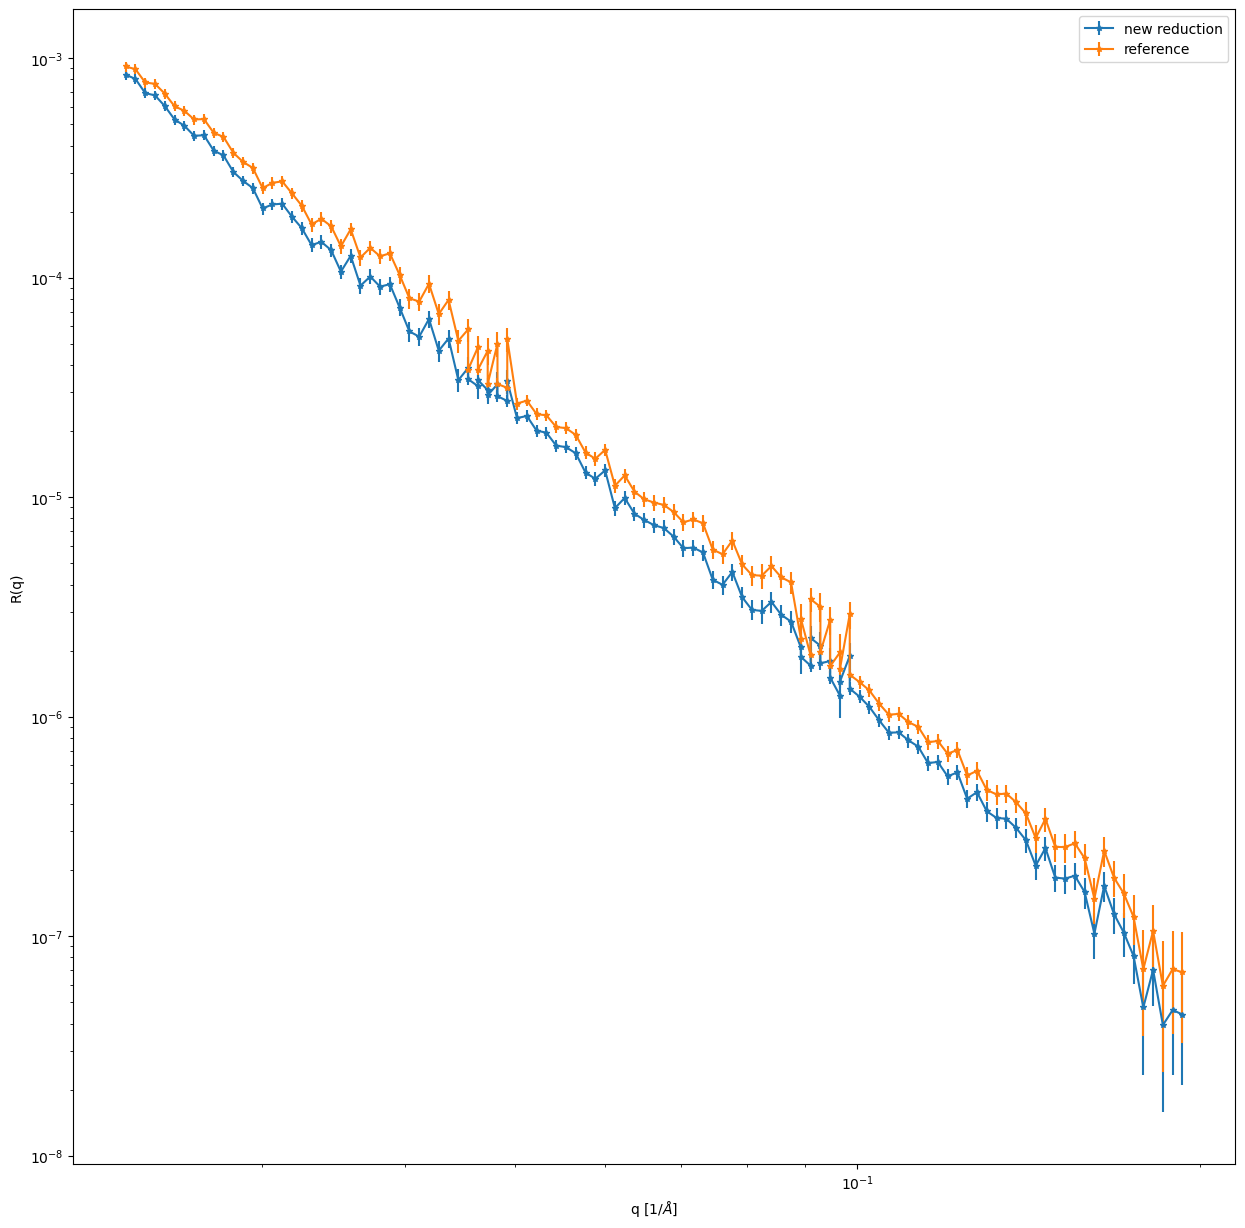

In [84]:
reduced_path = os.path.join(data_dir, 'reference_rq.txt')
reduced_path = os.path.join(data_dir, 'ref_206780_206594.txt')

if os.path.isfile(reduced_path):
    _data = np.loadtxt(reduced_path).T

reduced_path = os.path.join(data_dir, 'REFL_206780_combined_data_auto.txt')
if os.path.isfile(reduced_path):
    _refl = np.loadtxt(reduced_path).T

fig, ax = plt.subplots(figsize=(15,15))
#plt.errorbar(_refl[0], _refl[1]*_refl[0]**4, yerr=_refl[2]*_refl[0]**4, markersize=4, marker='*', linestyle='', label='new reduction')
#plt.errorbar(_data[0], _data[1]*_data[0]**4, yerr=_data[2]*_data[0]**4, markersize=4, marker='', linestyle='-', label='reference')
plt.errorbar(_refl[0], _refl[1], yerr=_refl[2], markersize=4, marker='*', linestyle='-', label='new reduction')
plt.errorbar(_data[0], _data[1], yerr=_data[2], markersize=4, marker='*', linestyle='-', label='reference')

plt.legend()
plt.xlabel('q [$1/\AA$]')
plt.ylabel('R(q)')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()




R_max 0.23809523809523808


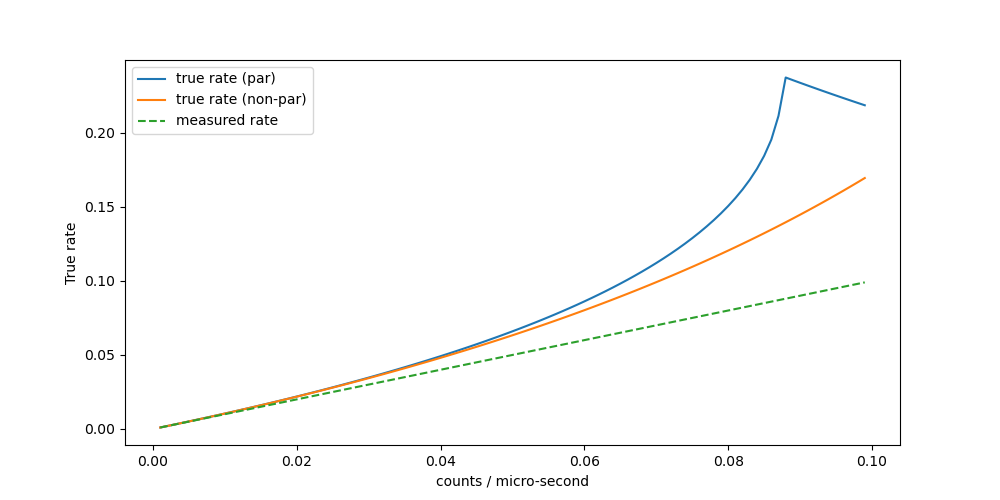

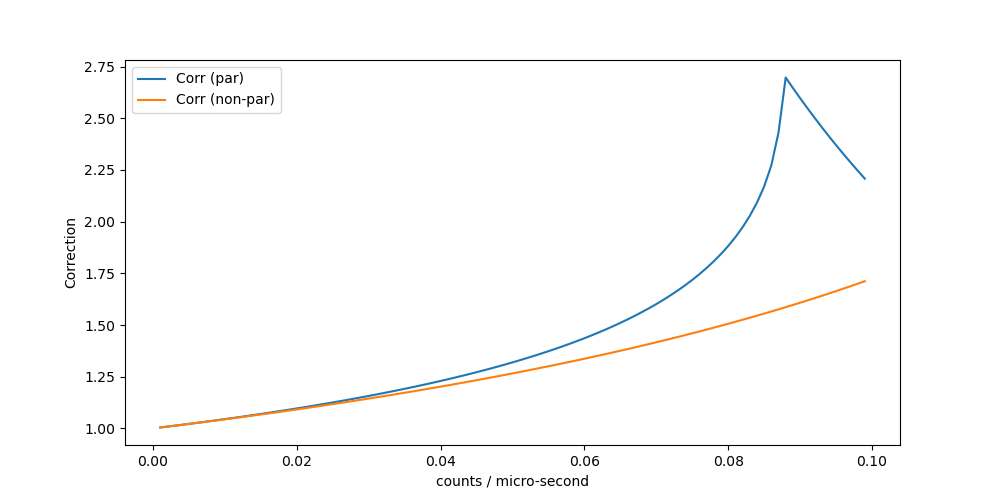

In [93]:
import scipy
# Rate is counts per microsecond
rate_db = np.arange(0.001, .1, 0.001)
dead_time = 4.2


meas_par = -scipy.special.lambertw(-rate_db * dead_time).real / dead_time
corr_npar = 1/(1 - rate_db * dead_time )

meas_npar = corr_npar * rate_db 

r_max = 1/dead_time

print("R_max", r_max)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(rate_db, meas_par, label='true rate (par)')
plt.plot(rate_db, meas_npar, label='true rate (non-par)')
plt.plot(rate_db, rate_db, linestyle='--', label='measured rate')
plt.legend()
plt.xlabel('counts / micro-second')
plt.ylabel('True rate')
plt.show()


fig, ax = plt.subplots(figsize=(10,5))
plt.plot(rate_db, meas_par/rate_db, label='Corr (par)')
plt.plot(rate_db, meas_npar/rate_db, label='Corr (non-par)')

plt.legend()
plt.xlabel('counts / micro-second')
plt.ylabel('Correction')
plt.show()

In [8]:
importlib.reload(workflow)
importlib.reload(output)
importlib.reload(event_reduction)
importlib.reload(reduction_template_reader)

data_dir = os.path.expanduser('~/git/LiquidsReflectometer/reduction/data')
template_path = os.path.join(data_dir, 'template.xml')



def write_template(template_file, output_dir):
    #self.data_peak_range = [140, 150]
    #self.background_roi = [137, 153,100, 200]

    with open(template_file, "r") as fd:
        xml_str = fd.read()
        data_sets = reduction_template_reader.from_xml(xml_str)

        # Left background
        for i in range(8):          
            print("Peak: %s" % data_sets[i].data_peak_range)
            data_sets[i].background_roi[0] = data_sets[i].data_peak_range[0]-5
            data_sets[i].background_roi[1] = data_sets[i].data_peak_range[0]

        xml_str = reduction_template_reader.to_xml(data_sets)
        with open(os.path.join(output_dir, 'template_left.xml'), 'w') as fd:
            fd.write(xml_str)

        # Right background
        for i in range(8):          
            data_sets[i].background_roi[0] = data_sets[i].data_peak_range[1]
            data_sets[i].background_roi[1] = data_sets[i].data_peak_range[1]+5

        xml_str = reduction_template_reader.to_xml(data_sets)
        with open(os.path.join(output_dir, 'template_right.xml'), 'w') as fd:
            fd.write(xml_str)

        # Invalid background
        for i in range(8):          
            data_sets[i].background_roi[0] = data_sets[i].data_peak_range[0]+1
            data_sets[i].background_roi[1] = data_sets[i].data_peak_range[1]-1

        xml_str = reduction_template_reader.to_xml(data_sets)
        with open(os.path.join(output_dir, 'template_invalid.xml'), 'w') as fd:
            fd.write(xml_str)


write_template(template_path, data_dir)
template_path_left = os.path.join(data_dir, 'template_left.xml')
template_path_right = os.path.join(data_dir, 'template_right.xml')
template_path_invalid = os.path.join(data_dir, 'template_invalid.xml')

for i in range(198409, 198417):
    ws = api.Load("REF_L_%s" % i)
    workflow.reduce(ws, template_path_invalid, output_dir=data_dir, pre_cut=1, post_cut=1, average_overlap=False)



Peak: [136, 147]
Peak: [136, 147]
Peak: [136, 147]
Peak: [136, 147]
Peak: [136, 147]
Peak: [136, 147]
Peak: [134, 148]
Peak: [134, 148]
wl=15; ths=-0.600382; thi=-0.00812677; No offset
Invalid background: [137 146]
wl=12.386; ths=-0.600058; thi=-0.00812677; No offset
Invalid background: [137 146]
wl=9.74; ths=-0.600058; thi=-0.00812677; No offset
Invalid background: [137 146]
wl=7.043; ths=-0.599896; thi=-0.00812677; No offset
Invalid background: [137 146]
wl=4.25; ths=-0.599733; thi=-0.00812677; No offset
Invalid background: [137 146]
wl=4.25; ths=-1.18271; thi=-0.00812677; No offset
Invalid background: [137 146]
wl=4.25; ths=-2.34284; thi=-0.00812677; No offset
Invalid background: [135 147]
wl=4.25; ths=-4.63906; thi=-0.00812677; No offset
Invalid background: [135 147]


In [12]:
importlib.reload(workflow)
importlib.reload(output)
importlib.reload(template)
importlib.reload(event_reduction)
importlib.reload(reduction_template_reader)

# IPTS-26010
# 192872, 191674, 190189, 187797: quartz
# 192879, 190202, 187804: inverted quartz
# 193204: SiO2

# IPTS-29196
# 201364: quartz
# 201074: D2O
# 201083: Mo in cell

# IPTS-30101
# 197900: quartz

# IPTS-29815
# 201446: Rana

# IPTS-28210
# 193773: quartz

# Frank IPTS-28412
# 191499 (cell up to 0.4)

run_number = 201282
IPTS = 29196

run_number = 194385
IPTS = 28342

data_dir = os.path.expanduser('~/git/LiquidsReflectometer/reduction/data')
template_path = "/SNS/REF_L/IPTS-%s/shared/autoreduce/REF_L_%s_auto_template.xml" % (IPTS, run_number)
template_path = "/SNS/REF_L/IPTS-28342/shared/autoreduce/194391-no-bck.xml"


for i in range(run_number, run_number+7):
    ws = api.Load("REF_L_%s" % i)
    thi = ws.getRun().getProperty("thi").value[0]
    workflow.reduce(ws, template_path, output_dir=data_dir, pre_cut=1, post_cut=1, average_overlap=False, q_summing=False)


wl=15; ths=0.599084; thi=0.00024715; No offset
wl=12.386; ths=0.599896; thi=0.00024715; No offset
wl=9.74; ths=0.600058; thi=0.00024715; No offset
wl=7.043; ths=0.599896; thi=0.00024715; No offset
wl=4.25; ths=0.600058; thi=0.00024715; No offset
wl=4.25; ths=1.1819; thi=0.00024715; No offset
Right side background: [158, 160]
wl=4.25; ths=2.34202; thi=0.00024715; No offset
Background on both sides: [143 145] [159 164]


In [31]:
reduced_path = "/SNS/REF_L/IPTS-%s/shared/autoreduce/REFL_%s_combined_data_auto.txt" % (IPTS, run_number)

if os.path.isfile(reduced_path):
    _data = np.loadtxt(reduced_path).T

reduced_path = os.path.join(data_dir, 'REFL_%s_combined_data_auto.txt' % run_number)
if os.path.isfile(reduced_path):
    _refl = np.loadtxt(reduced_path).T

fig, ax = plt.subplots(figsize=(10,5))
plt.errorbar(_refl[0], _refl[1], yerr=_refl[2], markersize=4, marker='.', linestyle='', label='new reduction')
plt.errorbar(_data[0], _data[1], yerr=_data[2], markersize=4, marker='', linestyle='-', label='old')

plt.legend()
plt.xlabel('q [$1/\AA$]')
plt.ylabel('R(q)')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()


NameError: name 'IPTS' is not defined

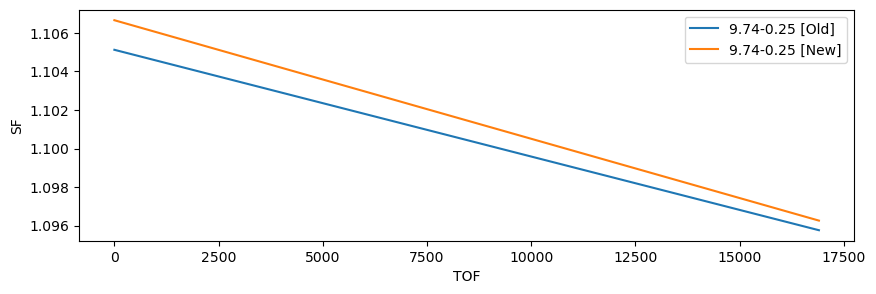

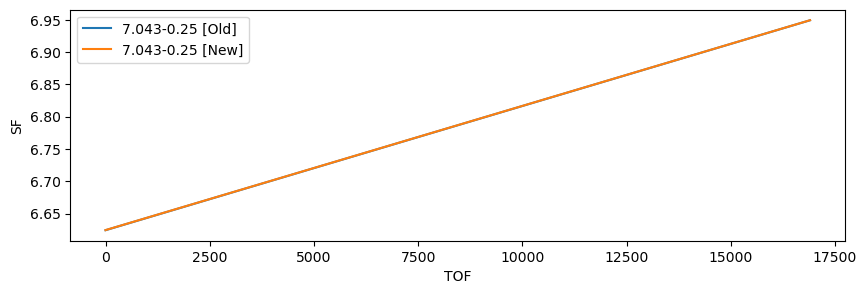

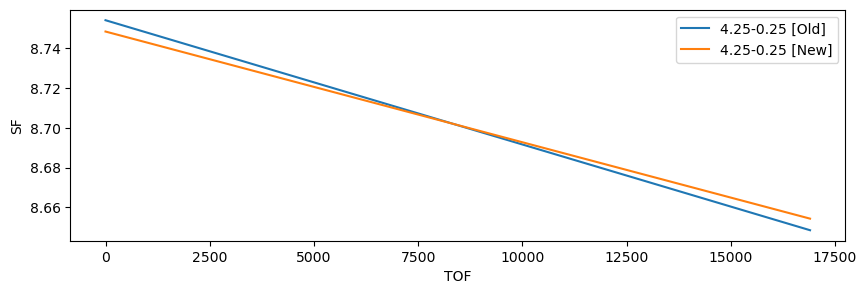

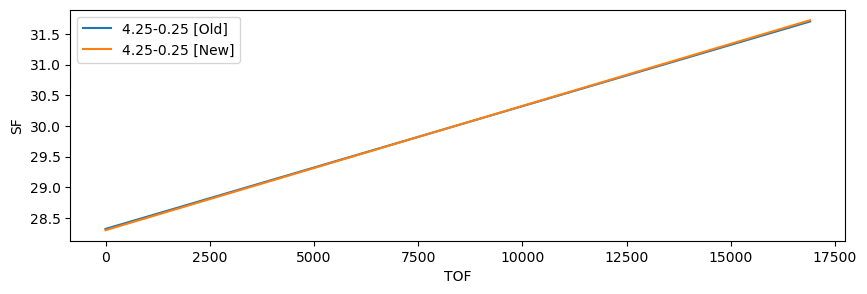

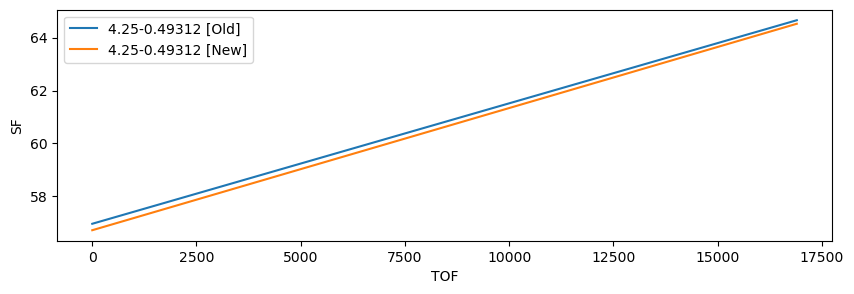

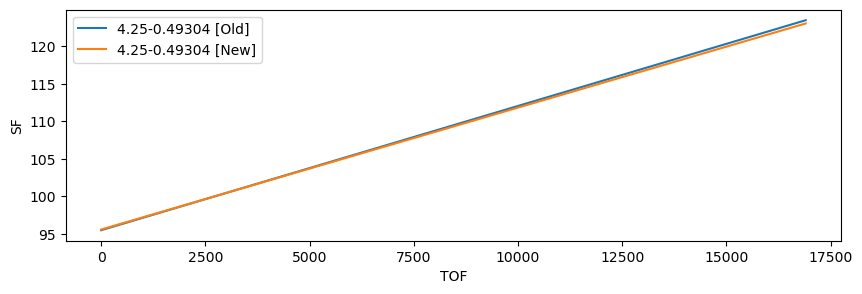

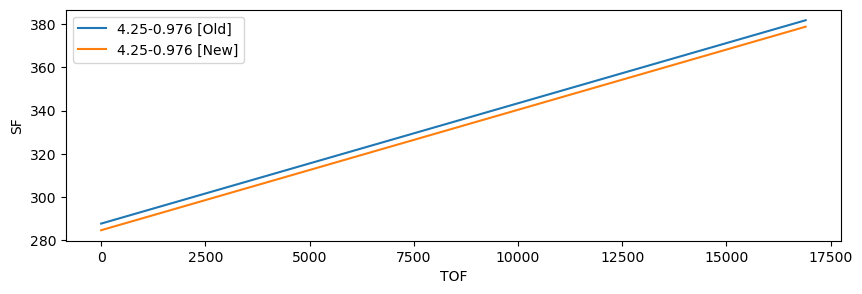

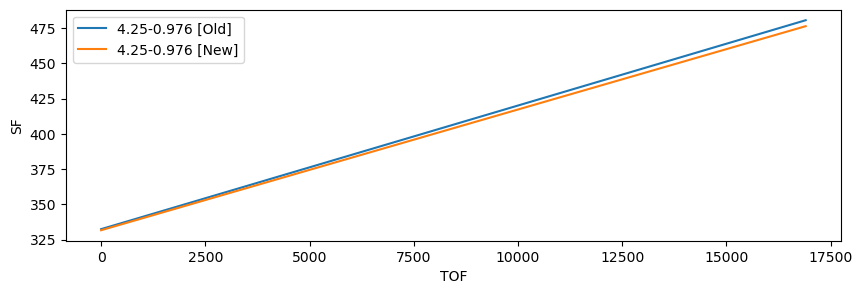

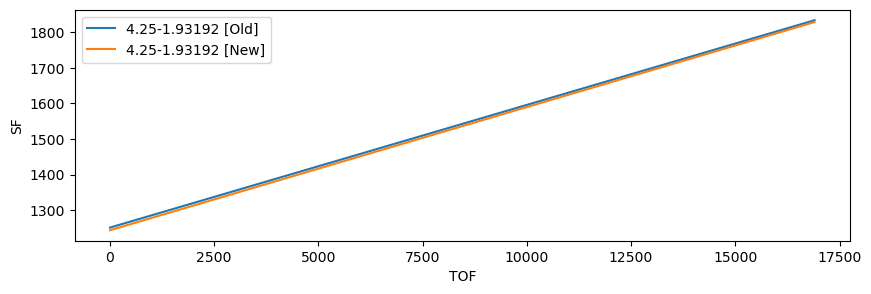

In [46]:

def get_sf(sf_file):
    par_list = []
    with open(sf_file, "r") as fd:
        for l in fd.readlines():
            if not l.startswith('#'):
                toks = l.split(' ')
                pars = {}
                for t in toks:
                    kv = t.split('=')
                    if kv[0] == 'IncidentMedium':
                        continue
                    pars[kv[0]] = float(kv[1].replace('\n',''))
                par_list.append([pars['a'], pars['b'], pars['error_a'], pars['error_b'], '%s-%g' % (pars['LambdaRequested'], pars['S2iH'])])
    return par_list

old_pars = get_sf(os.path.join(data_dir, "sf_197912_Si_auto.cfg"))
new_pars = get_sf(os.path.join(data_dir, "sf_197912_Si_auto-new.cfg"))

tofs = np.arange(0, 17000, 100)

for i in range(len(old_pars)):
    sf = old_pars[i][1]*tofs + old_pars[i][0]
    dsf = np.sqrt(old_pars[i][3]**2 * tofs**2 + old_pars[i][2]**2)
    fig, ax = plt.subplots(figsize=(10,3))
    plt.plot(tofs, sf, label='%s [Old]' % old_pars[i][4])
    #plt.fill_between(tofs, sf-dsf, sf+dsf, alpha=0.2)

    sf = new_pars[i][1]*tofs + new_pars[i][0]
    dsf = np.sqrt(new_pars[i][3]**2 * tofs**2 + new_pars[i][2]**2)

    plt.plot(tofs, sf, label='%s [New]' %new_pars[i][4])
    #plt.fill_between(tofs, sf-dsf, sf+dsf, alpha=0.2)

    plt.legend()
    plt.xlabel('TOF')
    plt.ylabel('SF')
    plt.show()